# Imports And Dependencies

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os
import yaml

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninst

In [12]:
df = "/kaggle/input/multi-class-object-detection-challenge"

metadata = {
    "train" : f"{df}/Starter_Dataset/train/images",
    "val" : f"{df}/Starter_Dataset/val/images",
    "test" : f"{df}/testImages/images",
    "nc" : 2,
    "names" : ["cheerios", "soup"]
}

with open("metadata.yaml", "w") as file:
    yaml.dump(metadata, file)

In [13]:
train_imgs = "/kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/train/images"
train_labels = "/kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/train/labels"
val_imgs = "/kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/val/images"
val_labels = "/kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/val/labels"

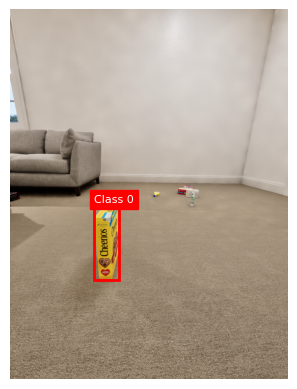

In [14]:
for label_file in os.listdir(train_labels):
    if not label_file.endswith(".txt"):
        continue

    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        lines = f.readlines()
        if not any(line.startswith("0") for line in lines):
            continue

    img_name = label_file.replace(".txt", ".png")
    img_path = os.path.join(train_imgs, img_name)

    if not os.path.exists(img_path):
        continue

    img = plt.imread(img_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for line in lines:
        cls, x, y, w, h = map(float, line.strip().split())
        if int(cls) != 0:
            continue

        img_h, img_w = img.shape[:2]
        x1 = (x - w/2) * img_w
        y1 = (y - h/2) * img_h
        box_w = w * img_w
        box_h = h * img_h

        rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"Class {int(cls)}", color='white', backgroundcolor='red', fontsize=8)

    plt.axis('off')
    plt.show()
    break  # remove this line to display all such images

In [15]:
i = 0
for img in os.listdir(train_labels):
    i = i+1

print(i)

1000


# Training The Model

In [ ]:
from ultralytics import YOLO

model = YOLO('yolo11m.pt')
metadata = "/kaggle/working/metadata.yaml"

model.train(
    data = metadata,
    epochs = 20,
    # time = 0.083,
    patience = 5,
    batch = 16,
    imgsz = 512,
    save = True,
    save_period = 5,
    device = 0,
    workers = 4,
    project="/kaggle/working",
    exist_ok = True,
    optimizer = "AdamW",
    seed = 12,
    multi_scale = True,
    cos_lr = True,
    close_mosaic = 10,
    # resume = True,
    lr0 = 0.001,
    lrf = 0.0001,
    weight_decay = 0.0005,
    warmup_epochs = 5,
    dropout = 0.4,
    plots = True,

    hsv_h = 0.5,
    hsv_s = 0.5,
    hsv_v = 0.5,
    degrees = 45,
    translate = 0.5,
    scale = 0.5,
    shear = 80,
    perspective = 0.001,
    flipud = 0.1,
    fliplr = 0.5,
    bgr = 0.01,
    mixup = 0.02,
    cutmix = 0.01,
    erasing = 0.1
)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.01, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.01, data=/kaggle/working/metadata.yaml, degrees=45, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.4, dynamic=False, embed=None, epochs=20, erasing=0.1, exist_ok=True, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.5, hsv_s=0.5, hsv_v=0.5, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.0001, mask_ratio=4, max_det=300, mixup=0.02, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=True, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=5, perspective=0.001, plots=True, pose=12.0, pretrained=

train: Scanning /kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/train/labels... 1000 images, 57 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:03<00:00, 250.24it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.9±2.0 ms, read: 862.3±495.3 MB/s, size: 11532.5 KB)


val: Scanning /kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/val/labels... 95 images, 2 backgrounds, 0 corrupt: 100%|██████████| 95/95 [00:02<00:00, 43.07it/s] 

WARNING ⚠️ val: Cache directory /kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/val is not writeable, cache not saved.


Plotting labels to /kaggle/working/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 4 dataloader workers
Logging results to /kaggle/working/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      12.8G      2.176      3.416      2.089         15        480: 100%|██████████| 63/63 [01:05<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         95        172      0.321      0.331      0.235     0.0933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      11.9G      2.177       2.82       2.17          9        768: 100%|██████████| 63/63 [00:50<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         95        172      0.174      0.392      0.157     0.0388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      12.3G      2.297      2.874      2.255         12        736: 100%|██████████| 63/63 [00:47<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all         95        172      0.261      0.436      0.181     0.0748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      12.2G      2.227      2.805      2.274         10        512: 100%|██████████| 63/63 [00:49<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         95        172      0.386      0.267      0.232     0.0715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      11.6G      2.367      2.882      2.325         23        448:  38%|███▊      | 24/63 [00:18<00:26,  1.48it/s]